<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial 9 - Spectral Shaping
23.12.2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

### Problem 7.1
* 1. Implement the PSD estimator (7.8).

In [ ]:
def PSD(x):
    num_seq = x.shape[0]
    len_seq = x.shape[1]
    x_f = np.fft.fft(x)
    PSD = np.abs(x_f)**2 / len_seq
    return np.mean(PSD, 0)

* 2. Sample the length $n = 10 000$ time signal $x$ with independent normal Gaussian
entries. Plot its PSD for $n_{seq} = \{10, 100, 1000\}$.

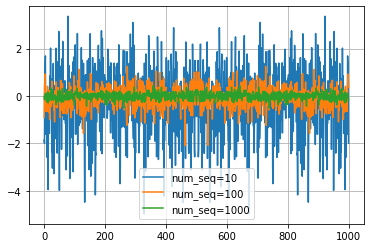

P_t=0.9983, P_f=0.9983


In [ ]:
len_seq = 1000
for num_seq in [10, 100, 1000]:
    x = np.random.randn(num_seq, len_seq)
    S_xx = PSD(x)
    P_t = np.mean(x**2)
    P_f = np.mean(S_xx)
    plt.plot(10*np.log10(S_xx), label=f'num_seq={num_seq}')
plt.grid()
plt.legend()
plt.show()
print(f'P_t={P_t :.4f}, P_f={P_f :.4f}')    

* 3. Consider now the signal $y$ with $$y_i = x_i + 0.5  x(i-1) \mod n$$

     Are the entries of $y_i$ independent?
 
 
 
* 4. Plot the PSD of $y$ for $n_{seq} = \{10, 100, 1000\}$.

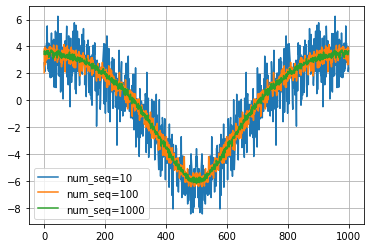

In [ ]:
alpha = 0.5
for num_seq in [10, 100, 1000]:
    x = np.random.randn(num_seq, len_seq)
    y = x + alpha * np.roll(x, 1)
    S_yy = PSD(y)
    plt.plot(10*np.log10(S_yy), label=f'num_seq={num_seq}')
plt.grid()
plt.legend()
plt.show()

* 5. Compare the plots of 2. and 4. with the ones obtained with scipy.signal.welch

In [ ]:
from scipy import signal

10
100
1000


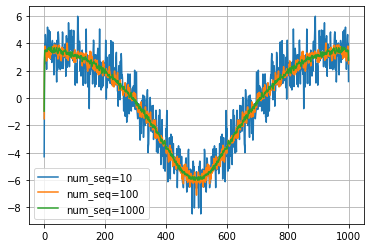

In [ ]:
for num_seq in [10, 100, 1000]:
    print(num_seq)
    x = np.random.randn(len_seq*num_seq)
    y = x + alpha * np.roll(x, 1)
    _, Syy = signal.welch(y, nperseg=len_seq, return_onesided=False)
    plt.plot(10*np.log10(Syy), label=f'num_seq={num_seq}')
plt.grid()
plt.legend()
plt.show()    

### Problem 7.2 - Filter Design by End-to-End Training

* 1. Carry out the end-to-end filter design described in Section 7.4 and plot the PSDs of the filtered signals.
* 2. Remove the low pass filter from the channel. Retrain the system and plot the PSDs of the filtered signals.
* 3. Exchange the low pass filter in the channel by interference as described in Section 7.1.2. Retrain the system and plot the PSDs of the filtered signals.
* 4. Exchange the low pass filter in the channel by the pilot tone as described in Section 7.1.3. Retrain the system and plot the PSDs of the filtered signals.

In [ ]:
import torch
import time

##### Auxiliary functions

In [ ]:
def downsample_td(signal, down):
    return down * signal[::down]

def upsample_td(signal, up):
    _signal = torch.zeros(len(signal) * up, dtype=signal.dtype)
    _signal[::up] = signal
    return _signal

def normalize(x):
    P = torch.mean(x**2)
    return x / torch.sqrt(P)

def get_filter_response(filt, fs, nperseg=100):
    x = torch.zeros(fs * nperseg)
    x[nperseg//2] = 1.
    h = tx_filter(x).detach().numpy()
    h = 1 / np.sqrt(np.sum(h**2)) * h
    Shh_dB = 10*np.log10(np.abs(np.fft.fft(h))**2)
    return h, Shh_dB

##### Communication system

In [ ]:
def mapper(n, M):
    a = np.random.choice(range(M), n)
    alphabet = np.arange(-(M-1), M, 2)
    x = alphabet[a]
    return torch.tensor(a), torch.tensor(x).float()

class Demapper(torch.nn.Module):
    def __init__(self, M, redundant=False):
        super().__init__()
        self.redundant = redundant
        if self.redundant:
            self.lin1 = torch.nn.Linear(1, 2 * M)
            self.lin2 = torch.nn.Linear(2 * M, M)
        else:
            self.lin = torch.nn.Linear(1, M)
        
    def forward(self, y):
        if self.redundant:
            return self.lin2(self.lin1(y))
        else:
            return self.lin(y)

class LinearFilter(torch.nn.Module):
    def __init__(self, num_taps):
        super().__init__()
        self.conv = torch.nn.Conv1d(in_channels=1,
                                    out_channels=1,
                                    kernel_size=num_taps,
                                    padding='same',
                                    bias=False)
    def forward(self, y):
        y = self.conv(y.reshape(1, 1, -1)).reshape(-1)
        return 1 / torch.sqrt(torch.mean(y**2)) * y
    
def transmitter(batch_size,
                M,
                ovs_factor,
                tx_filter):
    a, x = mapper(batch_size, M)
    power_x = torch.mean(x**2)
    
    u = upsample_td(x, ovs_factor)
    
    y_tx = tx_filter(u)
    y_tx = normalize(y_tx)
    
    return a, x, u, y_tx, power_x

def receiver(y_ch, power_x, rx_filter, ovs_factor, demapper):
    y_rx = rx_filter(y_ch.reshape(1, 1, -1)).reshape(-1)
    y_rx = normalize(y_rx)
    
    d = downsample_td(y_rx, ovs_factor)
    
    power_d = torch.mean(d**2)
    d = torch.sqrt(power_x / power_d) * d
    
    l = demapper(d.reshape(-1, 1))
    return y_rx, d, l

##### Plotting functions

In [ ]:
def scatterplot(x, d, show=True):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy().reshape(-1)
    if isinstance(d, torch.Tensor):
        d = d.detach().numpy().reshape(-1)
    plt.scatter(d[::2], d[1::2], s=1, label='d')
    plt.scatter(x[::2], x[1::2], s=1, label='x')
    plt.grid()
    plt.xlim((-8, 8))
    plt.ylim((-8, 8))
    plt.xticks(np.arange(-8, 9, 2))
    plt.yticks(np.arange(-8, 9, 2))
    plt.gca().set_aspect('equal')
    if show:
        plt.show()
        
def PSD(x, label, fs, nperseg=100, show=False, fftshift=False):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy().reshape(-1)
    f, Pxx = signal.welch(x, nperseg=nperseg * fs, return_onesided=False, fs=fs)
    if not fftshift:
        plt.plot(10*np.log10(Pxx), label=label)
    else:
        plt.plot(np.fft.fftshift(10*np.log10(Pxx)), linestyle='dashed', label=label)
    plt.grid()
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('power spectral density')
    if show:
        plt.show()

#### Low pass filter channel

In [ ]:
def get_rc_fd(filter_length, rolloff, samples_per_symbol):
    assert filter_length % 2 == 0, 'filter_length should be even'
    f = np.arange(-0.5, 0.5, 1 / filter_length)
    T = samples_per_symbol
    return _rc_fd(rolloff, T, f)

def _rc_fd(rolloff, T, f):
    Hf = np.cos(np.pi * T / 2 / rolloff *(np.abs(f) - (1 - rolloff) / 2 / T))**2
    idx = np.logical_and((1 - rolloff) / 2 / T < np.abs(f), np.abs(f) <= (1 + rolloff) / 2 / T)
    filter_fd = np.zeros_like(f)
    filter_fd[idx] = Hf[idx]
    idx1 = np.abs(f) <= (1 - rolloff) / 2 / T
    filter_fd[idx1] = 1.
    return np.fft.fftshift(filter_fd)

def filter_circ(signal, filter_fd):
    s_fd = torch.fft.fft(signal)
    signal_td = torch.fft.ifft(s_fd * filter_fd)
    return torch.real(signal_td).float()

def get_lpf(num_samples):
    filter_fd = torch.tensor(get_rc_fd(num_samples, 
                             rolloff=0.2, 
                             samples_per_symbol=8/5))
    return filter_fd

def channel_lpf(y, filter_fd, noise_variance):
    y_ch = filter_circ(y, filter_fd)
    return y_ch + np.sqrt(noise_variance) * torch.randn(y_ch.shape)

In [ ]:
n_epochs = 100_000
batch_size = 1000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.01
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
demapper = Demapper(M, redundant=True)
lpf_fd = get_lpf(ovs_factor * batch_size)

optimizer = torch.optim.Adam(list(tx_filter.parameters()) 
                             + list(rx_filter.parameters()) 
                             + list(demapper.parameters()), 
                             lr=1e-4)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    y_ch = channel_lpf(y_tx, lpf_fd, noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_lpf(y_tx, 
                           get_lpf(ovs_factor * 100_000), 
                           noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()

(Epoch 2426) XE=1.4052bits
(Epoch 4431) XE=1.0235bits
(Epoch 6541) XE=0.7278bits
(Epoch 8607) XE=0.5347bits
(Epoch 10659) XE=0.4382bits
(Epoch 12687) XE=0.3094bits
(Epoch 14687) XE=0.2004bits
(Epoch 16421) XE=0.1657bits
(Epoch 18302) XE=0.1525bits
(Epoch 20246) XE=0.0952bits
(Epoch 22267) XE=0.1162bits
(Epoch 24291) XE=0.0742bits
(Epoch 26270) XE=0.0619bits
(Epoch 28266) XE=0.1494bits
(Epoch 30279) XE=0.0768bits
(Epoch 32296) XE=0.1070bits
(Epoch 34347) XE=0.1118bits
(Epoch 36339) XE=0.0398bits
(Epoch 38355) XE=0.0857bits
(Epoch 40358) XE=0.0385bits
(Epoch 42401) XE=0.0434bits
(Epoch 44407) XE=0.0994bits
(Epoch 46452) XE=0.0676bits
(Epoch 48461) XE=0.0564bits
(Epoch 50456) XE=0.0348bits
(Epoch 52492) XE=0.0266bits
(Epoch 54506) XE=0.0800bits
(Epoch 56538) XE=0.0470bits
(Epoch 58561) XE=0.0606bits
(Epoch 60535) XE=0.0262bits
(Epoch 62575) XE=0.0246bits
(Epoch 64591) XE=0.0215bits
(Epoch 66615) XE=0.0196bits
(Epoch 68631) XE=0.0181bits
(Epoch 70626) XE=0.0140bits
(Epoch 72647) XE=0.0273b

In [ ]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
filter_fd = get_lpf(100_000 * ovs_factor)
y_ch = channel_lpf(y_tx, filter_fd, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

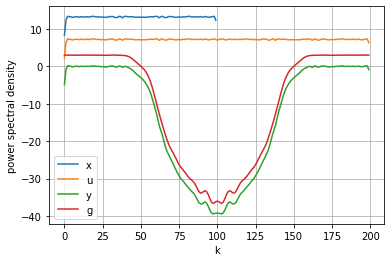

In [ ]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

C:\Users\ge49xuf\AppData\Local\Temp/ipykernel_11164/2352209912.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.abs(lpf)**2), label=r'$f$')


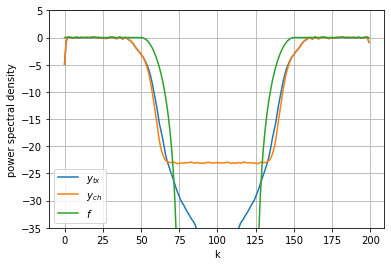

In [ ]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
lpf = get_lpf(200)
plt.plot(10*np.log10(np.abs(lpf)**2), label=r'$f$')
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

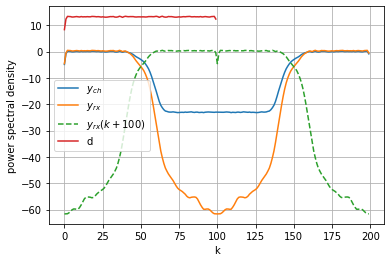

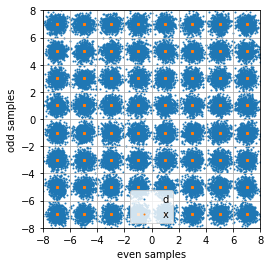

In [ ]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()

##### Without low-pass filter

In [ ]:
def channel_awgn(y, noise_variance):
    return y + np.sqrt(noise_variance) * torch.randn(y.shape)

In [ ]:
n_epochs = 500_000
batch_size = 1000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.01
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
demapper = Demapper(M, redundant=True)

optimizer = torch.optim.Adam(list(tx_filter.parameters()) 
                             + list(rx_filter.parameters()) 
                             + list(demapper.parameters()), 
                             lr=1e-4)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    y_ch = channel_awgn(y_tx, noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_awgn(y_tx, noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()

(Epoch 2281) XE=1.4946bits
(Epoch 4525) XE=1.0625bits
(Epoch 6726) XE=0.7582bits
(Epoch 8844) XE=0.5543bits
(Epoch 11038) XE=0.3886bits
(Epoch 13139) XE=0.2768bits
(Epoch 15239) XE=0.1855bits
(Epoch 17160) XE=0.1415bits
(Epoch 19183) XE=0.0993bits
(Epoch 21299) XE=0.0795bits
(Epoch 23381) XE=0.0599bits
(Epoch 25281) XE=0.0419bits
(Epoch 27128) XE=0.0412bits
(Epoch 29171) XE=0.0394bits
(Epoch 31272) XE=0.0300bits
(Epoch 33449) XE=0.0277bits
(Epoch 35603) XE=0.0224bits
(Epoch 37814) XE=0.0183bits
(Epoch 40008) XE=0.0156bits
(Epoch 42096) XE=0.0217bits
(Epoch 44158) XE=0.0178bits
(Epoch 46257) XE=0.0124bits
(Epoch 48306) XE=0.0188bits
(Epoch 50353) XE=0.0167bits
(Epoch 52370) XE=0.0149bits
(Epoch 54317) XE=0.0129bits
(Epoch 56303) XE=0.0189bits
(Epoch 58241) XE=0.0167bits
(Epoch 60232) XE=0.0156bits
(Epoch 62194) XE=0.0107bits
(Epoch 64080) XE=0.0109bits
(Epoch 66073) XE=0.0118bits
(Epoch 68044) XE=0.0106bits
(Epoch 70018) XE=0.0109bits
(Epoch 71907) XE=0.0106bits
(Epoch 73841) XE=0.0137b

In [ ]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
y_ch = channel_awgn(y_tx, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

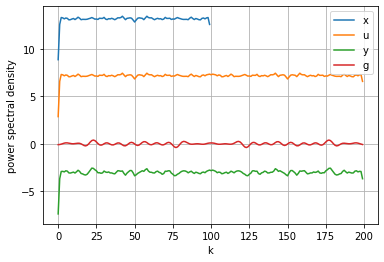

In [ ]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

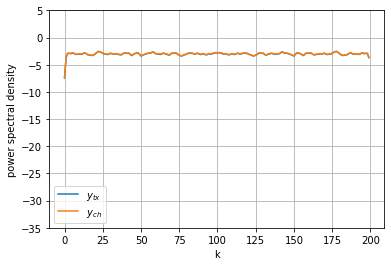

In [ ]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

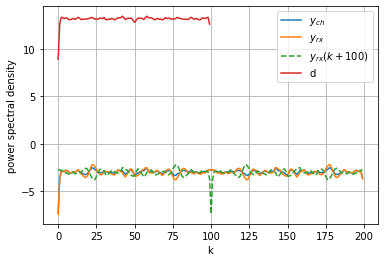

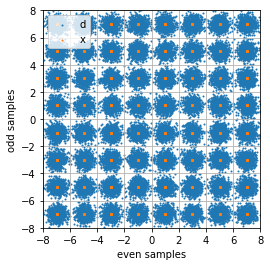

In [ ]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()

##### Interference Channel

In [ ]:
def filter_circ(signal, filter_fd):
    s_fd = torch.fft.fft(signal)
    signal_td = torch.fft.ifft(torch.fft.fftshift(s_fd * filter_fd))
    return torch.real(signal_td).float()

def get_rc(num_samples):
    filter_fd = torch.tensor(get_rc_fd(num_samples, 
                             rolloff=0.2, 
                             samples_per_symbol=2))
    return filter_fd

def channel_interf(y, filter_fd, noise_variance):
    interference_fd = torch.randn(y.shape)
    return y + filter_circ(interference_fd, filter_fd) + np.sqrt(noise_variance) * torch.randn(y.shape)

In [ ]:
n_epochs = 100_000
batch_size = 1000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.01
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
rc = get_rc(ovs_factor * batch_size)
demapper = Demapper(M, redundant=True)

optimizer = torch.optim.Adam(list(tx_filter.parameters()) 
                             + list(rx_filter.parameters()) 
                             + list(demapper.parameters()), 
                             lr=1e-4)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    y_ch = channel_interf(y_tx, rc, noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_interf(y_tx, 
                           get_rc(ovs_factor * 100_000), 
                           noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()

(Epoch 2158) XE=1.4770bits
(Epoch 4363) XE=1.0629bits
(Epoch 6573) XE=0.7691bits
(Epoch 8773) XE=0.5864bits
(Epoch 10950) XE=0.4665bits
(Epoch 13125) XE=0.3390bits
(Epoch 15292) XE=0.4002bits
(Epoch 17429) XE=0.2180bits
(Epoch 19523) XE=0.2492bits
(Epoch 21500) XE=0.2290bits
(Epoch 23518) XE=0.2202bits
(Epoch 25513) XE=0.2776bits
(Epoch 27446) XE=0.1261bits
(Epoch 29436) XE=0.4375bits
(Epoch 31433) XE=0.2667bits
(Epoch 33540) XE=0.1579bits
(Epoch 35640) XE=0.2615bits
(Epoch 37766) XE=0.2124bits
(Epoch 39850) XE=0.2316bits
(Epoch 41955) XE=0.2971bits
(Epoch 44051) XE=0.4051bits
(Epoch 46015) XE=0.4045bits
(Epoch 47979) XE=0.2276bits
(Epoch 49898) XE=0.1477bits
(Epoch 51882) XE=0.1270bits
(Epoch 53861) XE=0.2746bits
(Epoch 55761) XE=0.2197bits
(Epoch 57820) XE=0.2900bits
(Epoch 59962) XE=0.0979bits
(Epoch 62080) XE=0.1678bits
(Epoch 64203) XE=0.2929bits
(Epoch 66307) XE=0.2991bits
(Epoch 68410) XE=0.1109bits
(Epoch 70514) XE=0.1589bits
(Epoch 72647) XE=0.1665bits
(Epoch 74700) XE=0.4095b

In [ ]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
filter_fd = get_rc(100_000 * ovs_factor)
y_ch = channel_interf(y_tx, filter_fd, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

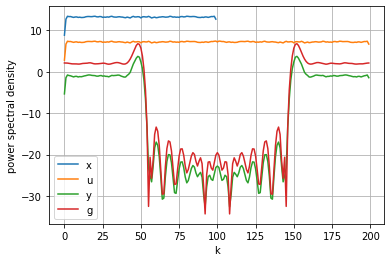

In [ ]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

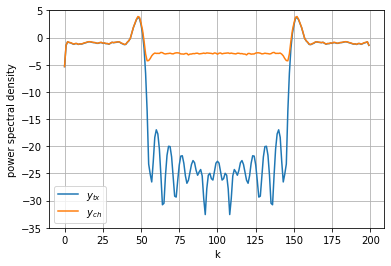

In [ ]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

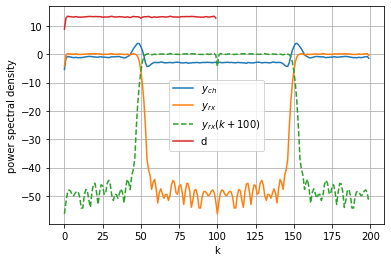

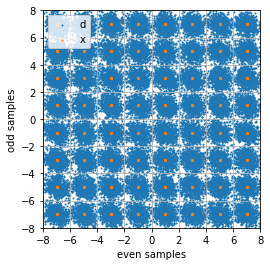

In [ ]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()

##### Pilot tone

In [ ]:
def get_pilot(n, ovs_factor, power):
    tone_fd = np.zeros(n * ovs_factor)
    f = int(0.2 * n)
    tone_fd[f - 1] = 0.1 * n
    tone_fd[f] = n
    tone_fd[f + 1] = 0.1 * n
    phase = np.random.rand()
    tone = np.real(np.fft.ifft(tone_fd * np.exp(2 * np.pi * phase)))
    return np.sqrt(power / np.mean(tone**2)) * tone

def channel_pilot_tone(y, ovs_factor, pilot_power, noise_variance):
    pilot = get_pilot(len(y)//ovs_factor, ovs_factor, pilot_power)
    y_ch = y + torch.tensor(pilot).float()
    return y_ch + np.sqrt(noise_variance) * torch.randn(y_ch.shape)

In [ ]:
n_epochs = 100_000
batch_size = 1000
M = 8
num_taps = 51
ovs_factor = 2
noise_variance = 0.01
pilot_power = 1
whichloss = 'ce'

loss_fn = torch.nn.CrossEntropyLoss()
msg_fn = lambda j, loss: print(f'(Epoch {j}) XE={loss/np.log(2) :.4f}bits')    

tx_filter = LinearFilter(num_taps)
rx_filter = LinearFilter(num_taps)
demapper = Demapper(M, redundant=True)

optimizer = torch.optim.Adam(list(tx_filter.parameters()) 
                             + list(rx_filter.parameters()) 
                             + list(demapper.parameters()), 
                             lr=1e-4)

start0 = time.time()
start = start0
losses = []
times = []

for j in range(n_epochs + 1):
    a, x, u, y_tx, power_x = transmitter(batch_size, M, ovs_factor, tx_filter)
    a = a.type(torch.LongTensor)
    y_ch = channel_pilot_tone(y_tx, ovs_factor, pilot_power, noise_variance)
    y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
    
    optimizer.zero_grad()
    loss = loss_fn(l, a)
    loss.backward()
    optimizer.step()
    
    if time.time() - start > 5:
        a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
        a = a.type(torch.LongTensor)
        y_ch = channel_pilot_tone(y_tx, ovs_factor, pilot_power, noise_variance)
        y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)
        losses.append(loss_fn(l, a).detach().numpy())
        msg_fn(j, loss)
        times.append(time.time()-start0)
        start = time.time()

(Epoch 1612) XE=1.7039bits
(Epoch 3188) XE=1.3479bits
(Epoch 4794) XE=1.0746bits
(Epoch 6428) XE=0.8298bits
(Epoch 7999) XE=0.6633bits
(Epoch 9634) XE=0.4973bits
(Epoch 11218) XE=0.3865bits
(Epoch 12699) XE=0.3043bits
(Epoch 14196) XE=0.2394bits
(Epoch 15745) XE=0.1856bits
(Epoch 17206) XE=0.1456bits
(Epoch 18724) XE=0.1106bits
(Epoch 20254) XE=0.0879bits
(Epoch 21821) XE=0.0714bits
(Epoch 23331) XE=0.0636bits
(Epoch 24823) XE=0.0558bits
(Epoch 26202) XE=0.0468bits
(Epoch 27649) XE=0.0453bits
(Epoch 29107) XE=0.0369bits
(Epoch 30593) XE=0.0312bits
(Epoch 32124) XE=0.0219bits
(Epoch 33664) XE=0.0284bits
(Epoch 35144) XE=0.0305bits
(Epoch 36633) XE=0.0210bits
(Epoch 38110) XE=0.0177bits
(Epoch 39683) XE=0.0185bits
(Epoch 41229) XE=0.0228bits
(Epoch 42783) XE=0.0199bits
(Epoch 44304) XE=0.0183bits
(Epoch 45797) XE=0.0211bits
(Epoch 47286) XE=0.0192bits
(Epoch 48774) XE=0.0203bits
(Epoch 50223) XE=0.0127bits
(Epoch 51546) XE=0.0218bits
(Epoch 52886) XE=0.0202bits
(Epoch 54223) XE=0.0146bit

In [ ]:
# Test dataset
a, x, u, y_tx, power_x = transmitter(100_000, M, ovs_factor, tx_filter)
y_ch = channel_pilot_tone(y_tx, ovs_factor, pilot_power, noise_variance)
y_rx, d, l = receiver(y_ch, power_x, rx_filter, ovs_factor, demapper)

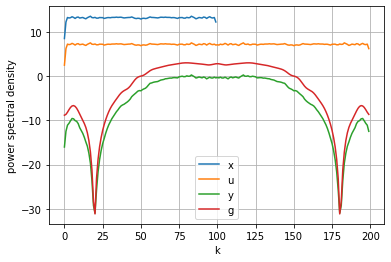

In [ ]:
# Transmitter
PSD(x, r'x', fs=1)
PSD(u, 'u', fs=2)
PSD(y_tx, 'y', fs=2)
h, Shh_dB = get_filter_response(tx_filter, fs=2)
plt.plot(Shh_dB, label='g')
plt.legend()
plt.show()

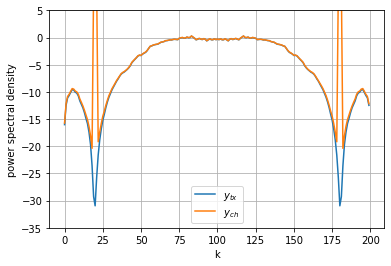

In [ ]:
# Channel
PSD(y_tx, r'$y_{tx}$', fs=2)
PSD(y_ch, r'$y_{ch}$', fs=2)
plt.grid()
plt.legend()
plt.ylim((-35, 5))
plt.show()

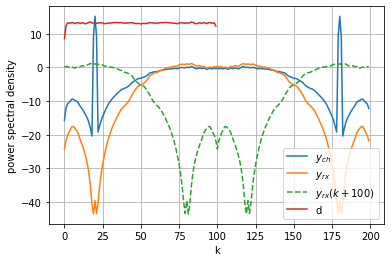

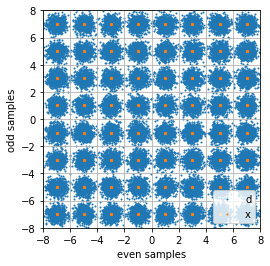

In [ ]:
# Receiver
PSD(y_ch, r'$y_{ch}$', fs=2)
PSD(y_rx, r'$y_{rx}$', fs=2)
PSD(y_rx, r'$y_{rx}(k + 100)$', fs=2, fftshift=True)
PSD(d, 'd', fs=1)
plt.grid()
plt.show()
scatterplot(x, d, show=False)

plt.xlabel('even samples')
plt.ylabel('odd samples')
plt.legend()
plt.show()